In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.datasets import fetch_20newsgroups
import stop_words
import gensim
import nltk
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
EXCLUDE_SYMBOLS_STR = ''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є',
                               '‹', '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—',
                               '‘', '\x7f', '\xad', '¤', '\xa0'])

In [35]:
regex_puncts = re.compile('[%s]' % re.escape(string.punctuation))
regex_symbs = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_digits = re.compile('[%s]' % re.escape(string.digits))
regex_spaces = re.compile('[%s]' % string.printable + string.whitespace)
regex_emoji = re.compile("["
                         "\U0001F600-\U0001F64F"  # emoticons
                         "\U0001F300-\U0001F5FF"  # symbols & pictographs
                         "\U0001F680-\U0001F6FF"  # transport & map symbols
                         "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         "]+")
morph = pymorphy2.MorphAnalyzer()

N_TOPICS = 20

---

In [5]:
data_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes')).data

print(len(data_train))

11314


### Preprocessing

In [6]:
texts_prep = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', txt) for txt in data_train]

In [7]:
texts_prep = [regex_emoji.sub(' ', txt) for txt in texts_prep]

In [8]:
texts_prep = [regex_puncts.sub(' ', txt) for txt in texts_prep]

In [9]:
texts_prep = [regex_symbs.sub('', txt) for txt in texts_prep]

In [10]:
texts_prep = [regex_digits.sub(' ', txt) for txt in texts_prep]

In [11]:
texts_prep = [regex_spaces.sub(' ', txt) for txt in texts_prep]

In [12]:
texts_prep = [txt.strip().replace('\t', ' ').replace('\n', ' ').lower() for txt in texts_prep]

In [13]:
texts_prep = [re.sub( '\s+', ' ', txt).strip() for txt in texts_prep]

In [14]:
texts_prep[:20]

['i was wondering if anyone out there could enlighten me on this car i saw the other day it was a door sports car looked to be from the late s early s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail',
 'a fair number of brave souls who upgraded their si clock oscillator have shared their experiences for this poll please send a brief message detailing your experiences with the procedure top speed attained cpu rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with and m floppies are especially requested i will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and haven t answered this poll thanks',
 'well folks my mac plus fin

In [15]:
stops = stop_words.get_stop_words('en')
wnl = nltk.WordNetLemmatizer()
stemmer = PorterStemmer()

In [16]:
corpus = []

for sentence in log_progress(texts_prep[::]):
    tokens = sentence.split(' ')
#     tokens = [t for t in tokens if t not in stops]
    tokens = [wnl.lemmatize(t) for t in tokens if t not in stops]
#     tokens = [stemmer.stem(t) for t in tokens if t not in stops]
    tokens = [t for t in tokens if len(t) >= 3]
    corpus.append(tokens)

## LSA

**LSA = TFIDF + SVD**

In [24]:
vectorizer = TfidfVectorizer()

In [25]:
X = vectorizer.fit_transform([' '.join(tokens) for tokens in corpus])

print(X.shape)

(11314, 66434)


In [26]:
vectorizer.vocabulary_

{'wondering': 63311,
 'anyone': 2444,
 'enlighten': 17169,
 'car': 7758,
 'saw': 50239,
 'day': 12692,
 'door': 15169,
 'sport': 53542,
 'looked': 32983,
 'late': 31644,
 'early': 15973,
 'called': 7517,
 'bricklin': 6676,
 'really': 46943,
 'small': 52575,
 'addition': 637,
 'front': 20742,
 'bumper': 7075,
 'separate': 51094,
 'rest': 48182,
 'body': 6129,
 'know': 30829,
 'can': 7600,
 'tellme': 56300,
 'model': 36564,
 'name': 38064,
 'engine': 17126,
 'spec': 53289,
 'year': 65167,
 'production': 44758,
 'made': 33718,
 'history': 24681,
 'whatever': 62638,
 'info': 27158,
 'funky': 20958,
 'looking': 32985,
 'please': 43464,
 'mail': 33845,
 'fair': 18761,
 'number': 39695,
 'brave': 6572,
 'soul': 53093,
 'upgraded': 60071,
 'clock': 9510,
 'oscillator': 41050,
 'shared': 51432,
 'experience': 18395,
 'poll': 43775,
 'send': 51039,
 'brief': 6690,
 'message': 35327,
 'detailing': 13754,
 'procedure': 44714,
 'top': 57481,
 'speed': 53354,
 'attained': 3628,
 'cpu': 11498,
 'rate

In [27]:
keys = list(vectorizer.vocabulary_.keys())
values = list(vectorizer.vocabulary_.values())

_ind = np.argsort(values)
words_sorted = np.asarray(keys)[_ind]

print(len(keys), len(values), len(words_sorted))

66434 66434 66434


In [28]:
svd = TruncatedSVD(n_components=N_TOPICS, n_iter=10).fit(X)

['think' 'people' 'just' 'get' 'like' 'don' 'know' 'will' 'one' 'can']
[0.11007054 0.12416159 0.12631413 0.12664011 0.12709212 0.12859254
 0.13387476 0.16681244 0.1683749  0.19976597]

['anyone' 'program' 'please' 'disk' 'driver' 'thanks' 'file' 'card'
 'drive' 'window']
[0.09787488 0.09902556 0.1032703  0.11215248 0.12249486 0.17475411
 0.18150347 0.19045382 0.20526253 0.29534315]

['ide' 'disk' 'hard' 'player' 'car' 'year' 'scsi' 'team' 'game' 'drive']
[0.08086469 0.08426783 0.08810765 0.10035523 0.10169324 0.13790538
 0.14572514 0.14956299 0.22487803 0.37403016]

['bit' 'algorithm' 'phone' 'will' 'escrow' 'government' 'clipper'
 'encryption' 'chip' 'key']
[0.09030043 0.09124529 0.09552271 0.09791443 0.10558019 0.12984178
 0.14689933 0.17046288 0.24129793 0.4875309 ]

['controller' 'encryption' 'ide' 'system' 'disk' 'chip' 'scsi' 'god' 'key'
 'drive']
[0.085825   0.09067054 0.09097776 0.10400154 0.10880986 0.15970093
 0.17662747 0.18022696 0.25217864 0.38596997]

['skepticism' 'intel

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


['ftp' 'software' 'anyone' 'don' 'printer' 'version' 'mac' 'know' 'scsi'
 'driver']
[0.10131757 0.10420011 0.10870913 0.12044168 0.16086347 0.17024262
 0.17658707 0.1940096  0.21424216 0.23625095]

['armenian' 'monitor' 'mail' 'people' 'think' 'please' 'don' 'system'
 'car' 'problem']
[0.0990015  0.1021471  0.11315881 0.11786497 0.15112735 0.1582523
 0.18516647 0.28578694 0.30338089 0.32086471]

['don' 'card' 'port' 'irq' 'use' 'drive' 'one' 'will' 'car' 'com']
[0.09101381 0.1019751  0.11109635 0.11626122 0.12188578 0.12436012
 0.14227273 0.17321037 0.27504446 0.29714931]

['objective' 'think' 'problem' 'bike' 'thanks' 'game' 'system' 'will'
 'driver' 'one']
[0.09745824 0.11376764 0.11915    0.12780257 0.13836907 0.16490544
 0.16788585 0.18403389 0.24558994 0.41068404]

['don' 'car' 'program' 'bit' 'will' 'space' 'key' 'gun' 'like' 'game']
[0.09380082 0.0966559  0.10113443 0.10259215 0.11860487 0.15750759
 0.17962146 0.21809787 0.23364907 0.42730469]

['motif' 'system' 'key' 'book' 'kn

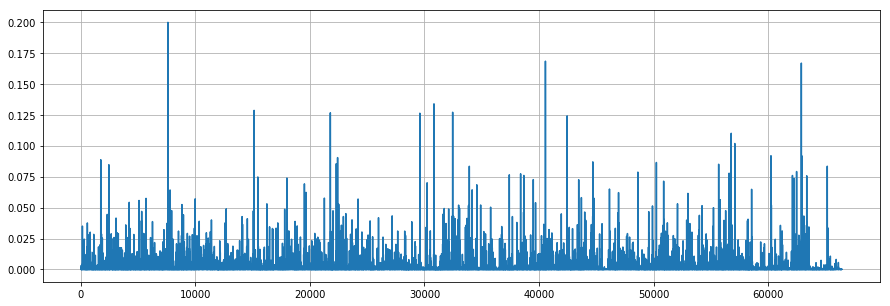

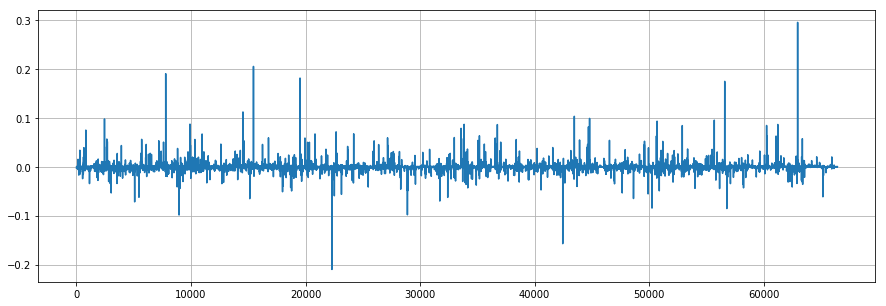

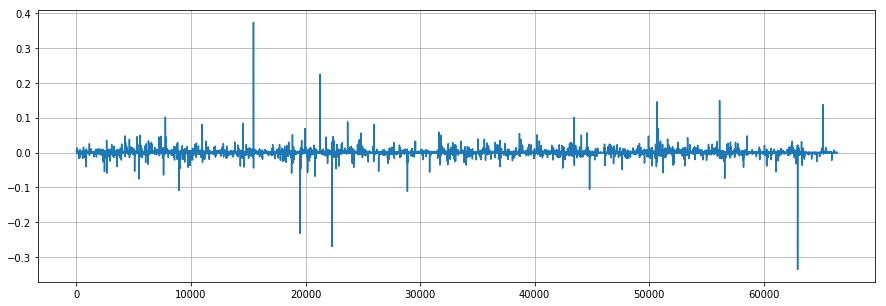

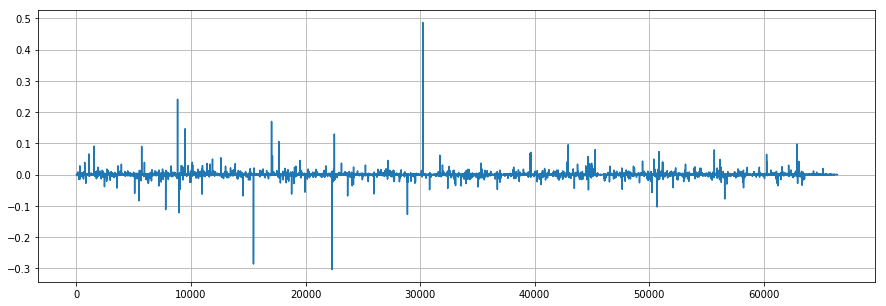

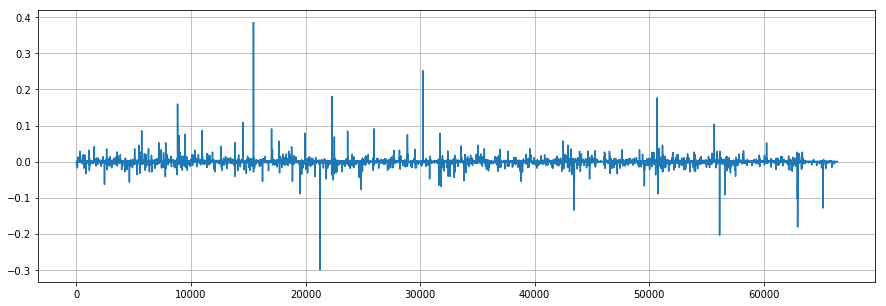

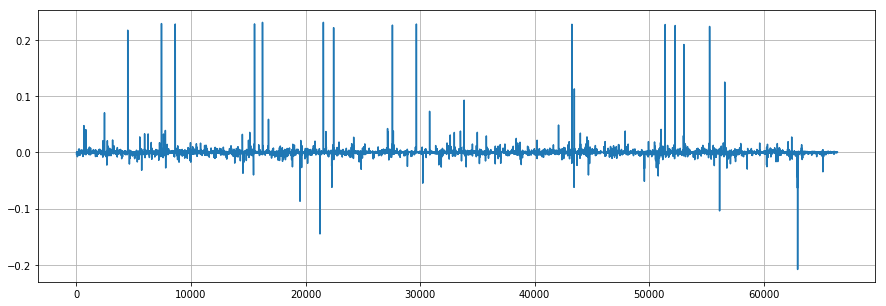

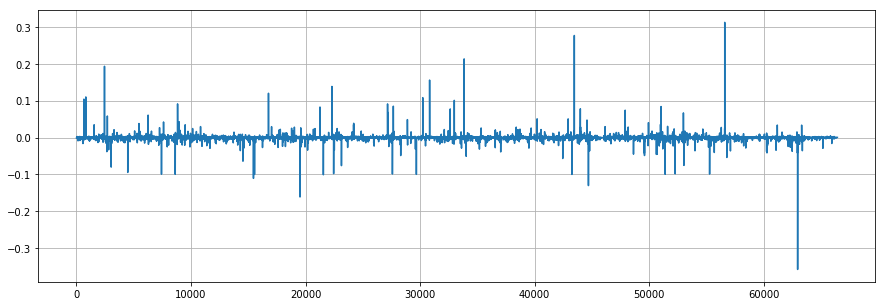

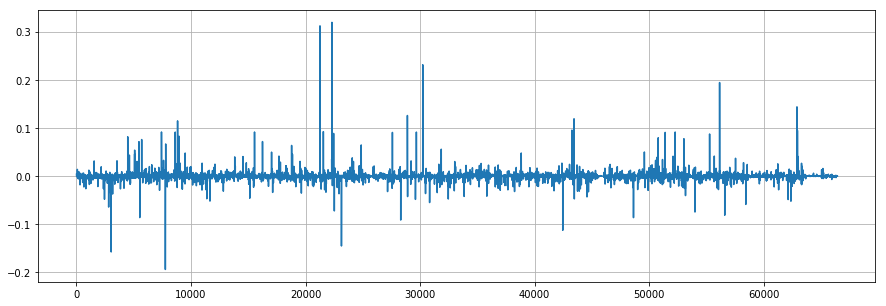

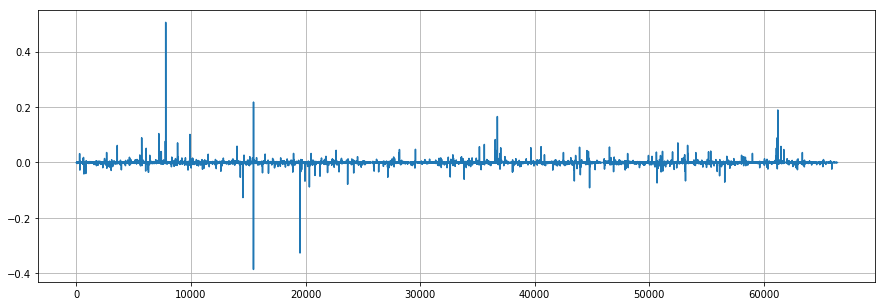

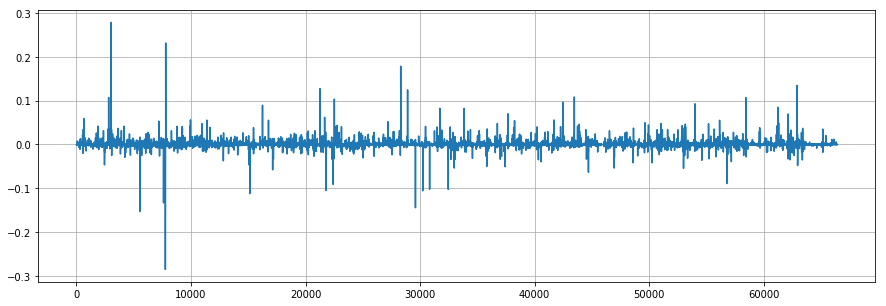

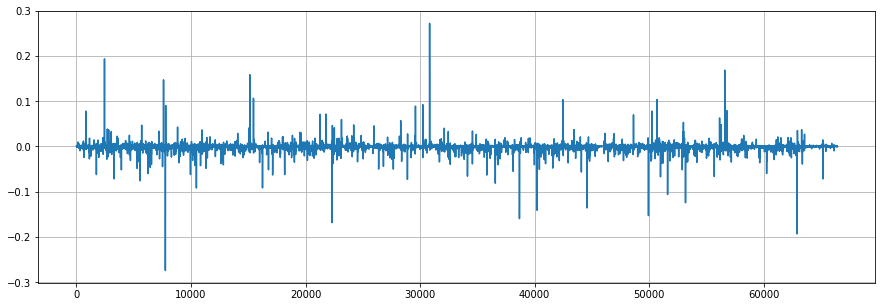

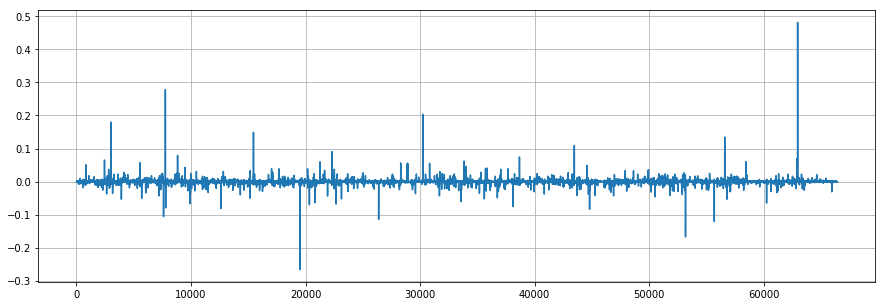

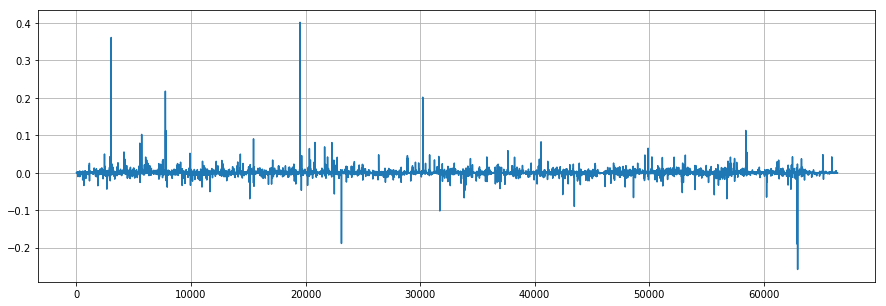

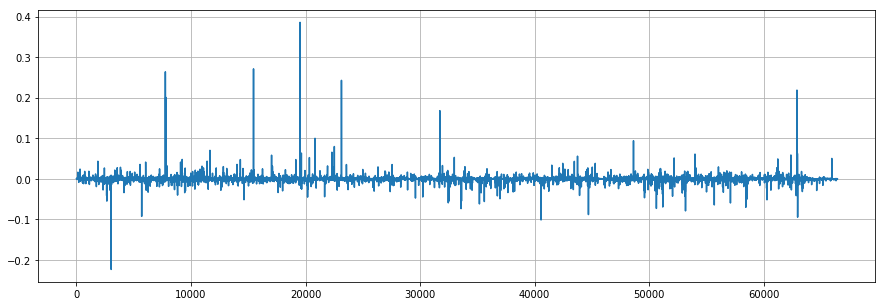

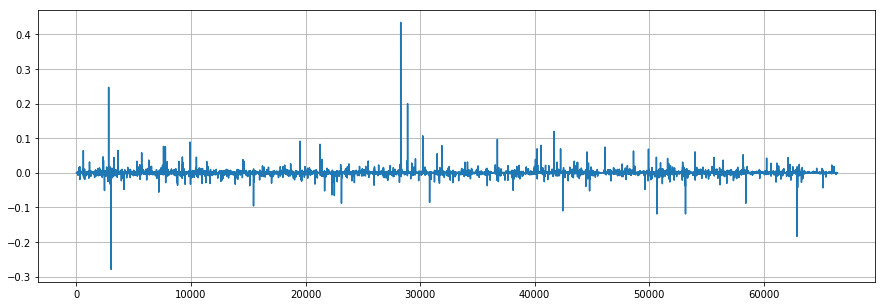

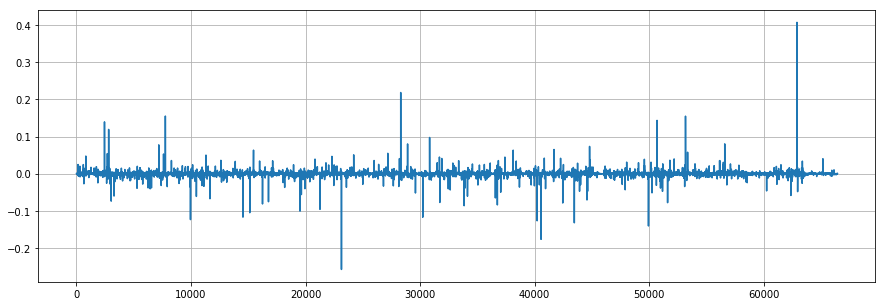

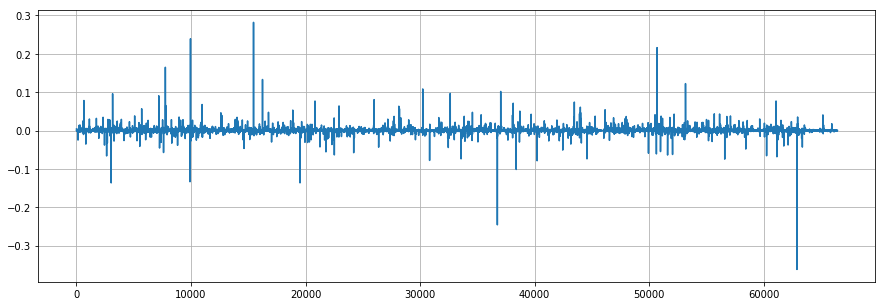

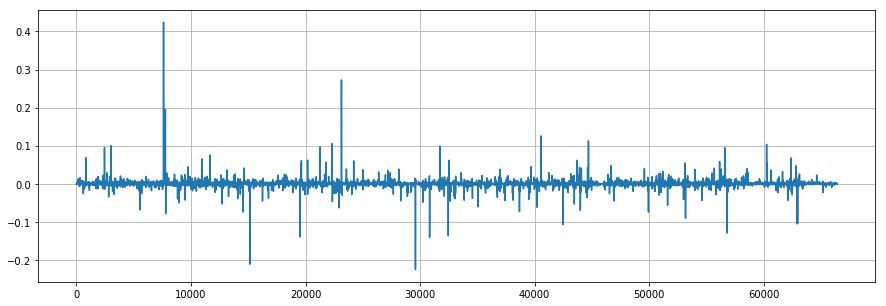

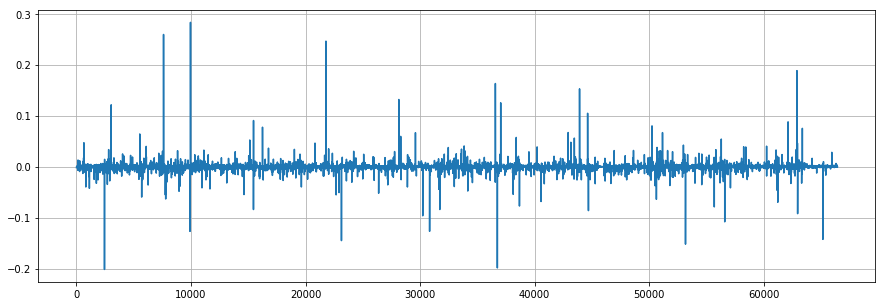

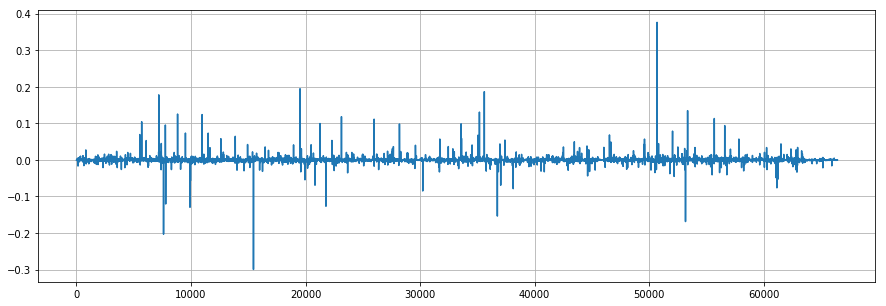

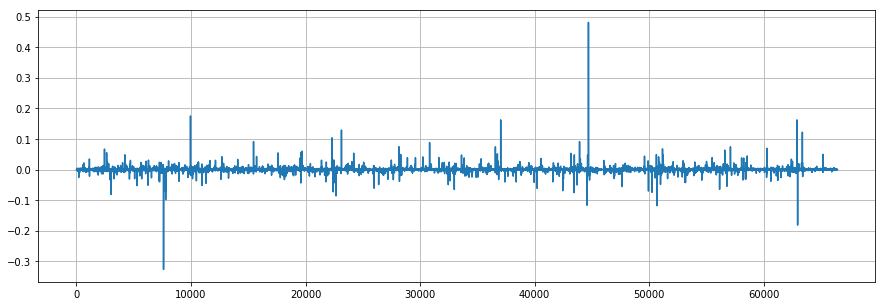

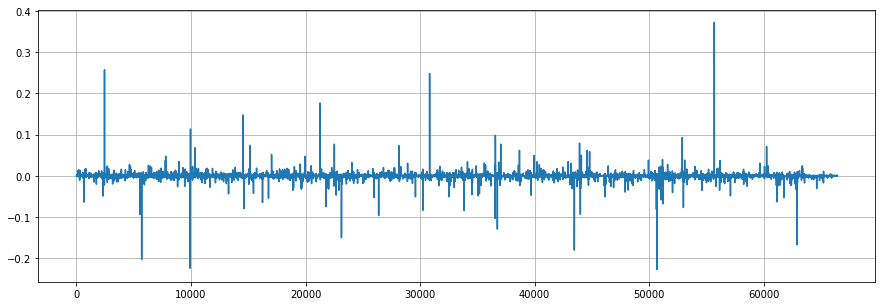

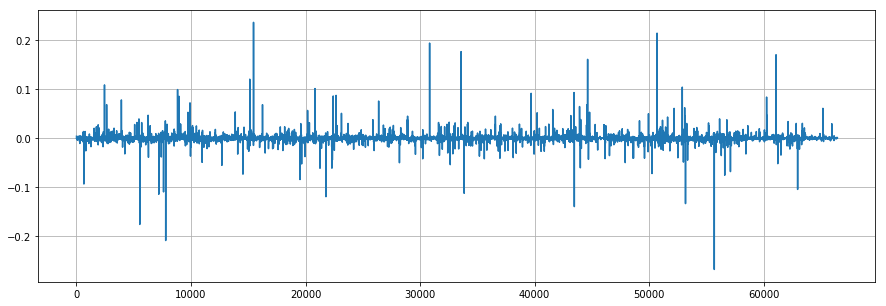

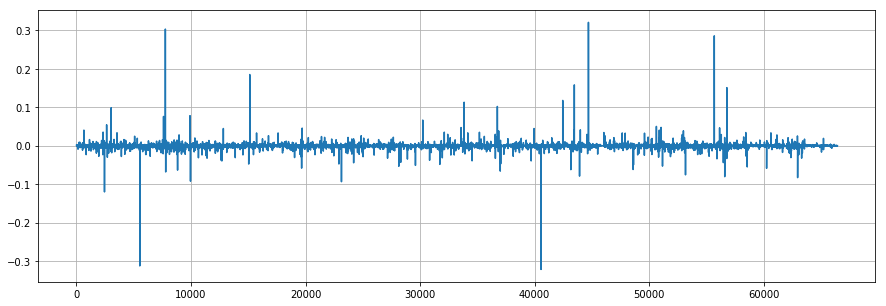

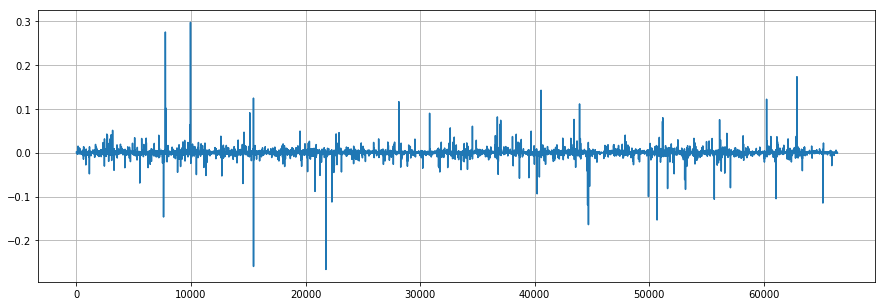

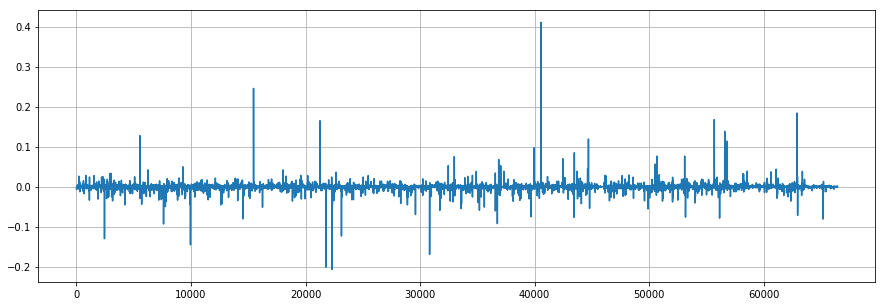

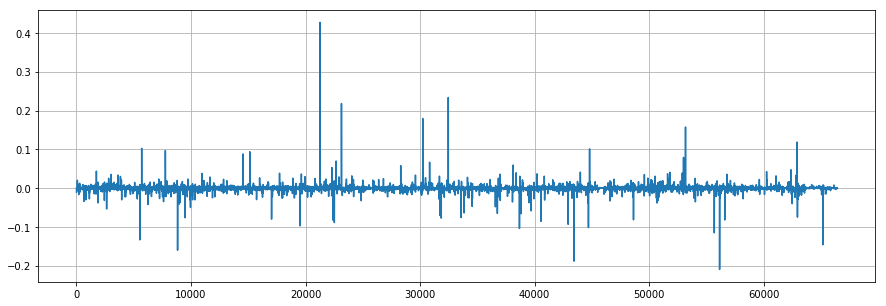

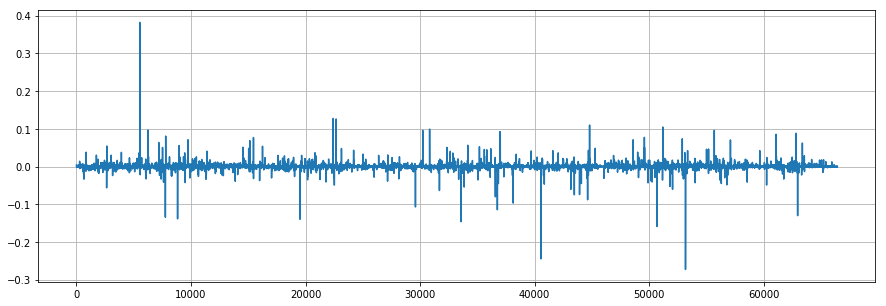

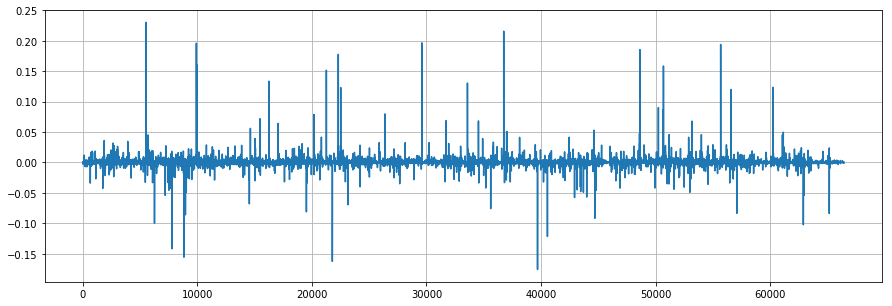

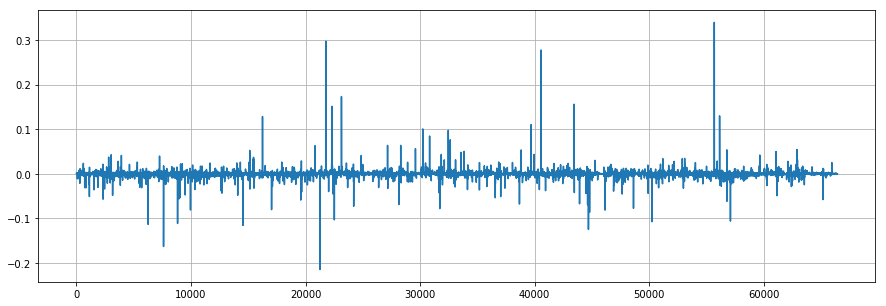

In [29]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(svd.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
    
    tmp = stub.copy()
    tmp[i] = 1
    plt.figure(figsize=(15, 5))
    plt.plot(svd.components_[i])
    plt.grid(True)
#     break

### [LSA gensim](https://radimrehurek.com/gensim/models/lsimodel.html)

## LDA

**LDA = LSA + Dirichlet**

### gensim

**[sklearn-like API](https://radimrehurek.com/gensim/sklearn_api/ldaseqmodel.html)**

In [39]:
dictionary = corpora.Dictionary(corpus)

In [40]:
X_bow = [dictionary.doc2bow(text) for text in corpus]

In [41]:
lda_gensim = gensim.models.ldamodel.LdaModel(X_bow, num_topics=N_TOPICS, id2word=dictionary, iterations=10)

In [42]:
lda_gensim.print_topics()

[(0,
  '0.012*"car" + 0.008*"will" + 0.008*"can" + 0.008*"key" + 0.006*"one" + 0.005*"use" + 0.005*"new" + 0.005*"like" + 0.004*"system" + 0.004*"time"'),
 (1,
  '0.016*"god" + 0.009*"one" + 0.009*"will" + 0.008*"people" + 0.008*"can" + 0.006*"jesus" + 0.006*"law" + 0.005*"just" + 0.005*"say" + 0.005*"think"'),
 (2,
  '0.010*"one" + 0.008*"gun" + 0.007*"can" + 0.006*"don" + 0.005*"just" + 0.005*"get" + 0.005*"year" + 0.005*"people" + 0.005*"say" + 0.004*"like"'),
 (3,
  '0.011*"armenian" + 0.007*"one" + 0.006*"first" + 0.005*"don" + 0.005*"year" + 0.005*"people" + 0.005*"say" + 0.005*"time" + 0.004*"said" + 0.004*"will"'),
 (4,
  '0.027*"entry" + 0.006*"rule" + 0.006*"will" + 0.005*"build" + 0.005*"program" + 0.005*"remark" + 0.004*"file" + 0.004*"one" + 0.004*"section" + 0.004*"year"'),
 (5,
  '0.011*"right" + 0.007*"state" + 0.007*"people" + 0.005*"jew" + 0.005*"greek" + 0.005*"president" + 0.005*"government" + 0.005*"amendment" + 0.005*"militia" + 0.004*"well"'),
 (6,
  '0.007*"one"

**[multi-core version](https://radimrehurek.com/gensim/models/ldamulticore.html)**

### sklearn

In [36]:
lda_sklearn = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

iteration: 1 of max_iter: 10, perplexity: 1301715.4517
iteration: 2 of max_iter: 10, perplexity: 1039107.1607
iteration: 3 of max_iter: 10, perplexity: 805773.5396
iteration: 4 of max_iter: 10, perplexity: 520507.5915
iteration: 5 of max_iter: 10, perplexity: 333995.4689
iteration: 6 of max_iter: 10, perplexity: 258710.3391
iteration: 7 of max_iter: 10, perplexity: 229019.9879
iteration: 8 of max_iter: 10, perplexity: 214525.5885
iteration: 9 of max_iter: 10, perplexity: 205740.5794
iteration: 10 of max_iter: 10, perplexity: 199962.9667


In [37]:
lda_sklearn.components_.shape

(20, 66434)

In [38]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(lda_sklearn.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
#     break

['greek' 'play' 'nhl' 'league' 'msg' 'playoff' 'season' 'player' 'team'
 'game']
[0.11007054 0.12416159 0.12631413 0.12664011 0.12709212 0.12859254
 0.13387476 0.16681244 0.1683749  0.19976597]

['inguiry' 'eridan' 'chuvashia' 'art' 'lib' 'minivan' 'kuiper' 'devguide'
 'ites' 'kariya']
[0.09787488 0.09902556 0.1032703  0.11215248 0.12249486 0.17475411
 0.18150347 0.19045382 0.20526253 0.29534315]

['hartford' 'chz' 'birthday' 'lib' 'alomar' 'libxmu' 'har' 'ink'
 'electricity' 'baerga']
[0.08086469 0.08426783 0.08810765 0.10035523 0.10169324 0.13790538
 0.14572514 0.14956299 0.22487803 0.37403016]

['pit' 'insisting' 'chi' 'shafer' 'garrett' 'lindros' 'ames' 'dryden'
 'period' 'flyer']
[0.09030043 0.09124529 0.09552271 0.09791443 0.10558019 0.12984178
 0.14689933 0.17046288 0.24129793 0.4875309 ]

['skepticism' 'dsl' 'chastity' 'jxp' 'intellect' 'surrender' 'shameful'
 'cadre' 'geb' 'pitt']
[0.085825   0.09067054 0.09097776 0.10400154 0.10880986 0.15970093
 0.17662747 0.18022696 0.25217

### [Dynamic topic modeling (gensim)](https://radimrehurek.com/gensim/models/ldaseqmodel.html)